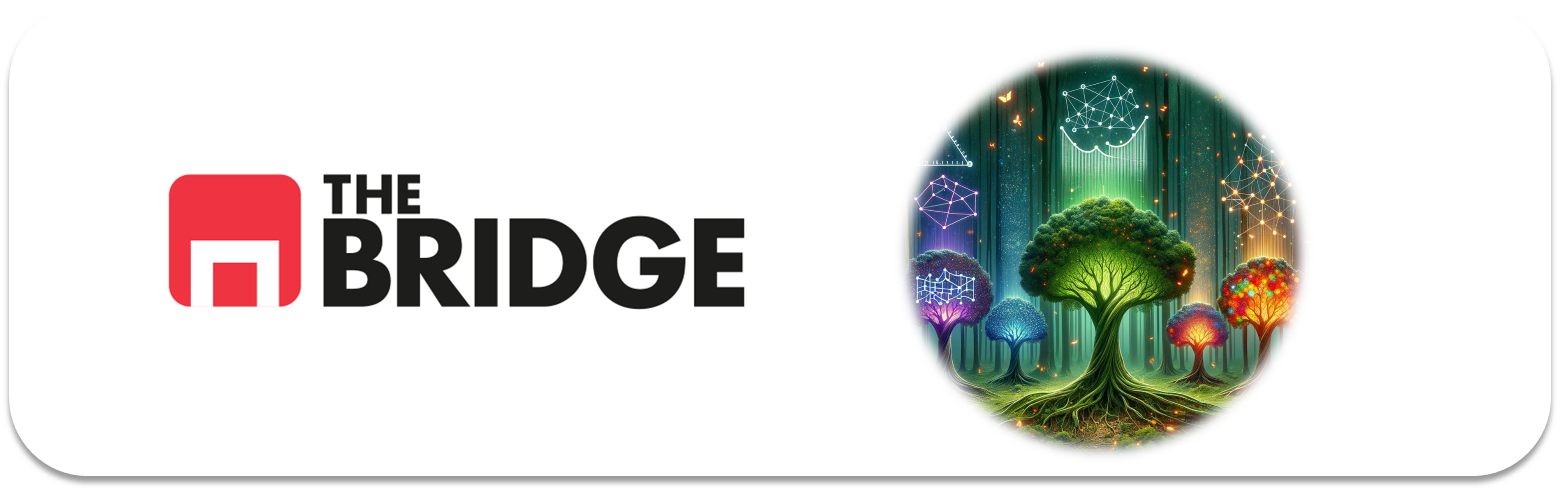

## PRACTICA OBLIGATORIA: **Arboles de Decisión y Ajuste de hiperparámetros**

* La práctica obligatoria de esta unidad consiste en encontrar el mejor modelo para resolver un problema de predicción de si los destinatarios de una campaña de marketing adquirirán un producto concreto. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier


### Descripción

En el directorio data encontrarás un dataset que contiene datos relacionados con campañas de marketing directo de una institución bancaria portuguesa (es el dataset "Bank Marketing" de la UCI Machine Learning Repository). Los datos se recopilaron de campañas de marketing telefónico, donde el objetivo principal era predecir si el cliente se suscribiría a un depósito a plazo.

La práctica consiste en completar el proceso de creación de un modelo basado en árboles de decisión que permita predecir si un cliente (dadas unas características similares a las del dataset) "comprará" el depósito a plazo. Sigue los pasos necesarios de un proceso de ML para crear el modelo, optimizar sus hiperparámetros, comparar los resultados de esa optimización con una regresión logística (sin optimizar, con sus hiperparámetros por defecto) y finalmente evaluarlo contra test y hacer una pequeña valoración del resultado obtenido.

Tendrás que hacer la limpieza, split, minieda, selección, tratamiento, primeros entrenamientos, optimización, comparación y evaluación según tu mejor criterio. Eso sí, es obligatorio:
- Identificar el target y analizar su distribución
- Realizar una optimización de hiperparámetros, escogiendo un grid medianemante razonado
- Comparar con el modelo baseline
- Evaluar contra test

AYUDA: La dirección del banco nos proporciona estas notas (en inglés):

 
   **bank client data:**  
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
                                       "blue-collar","self-employed","retired","technician","services")   
   3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "unknown","secondary","primary","tertiary")  
   5 - default: has credit in default? (binary: "yes","no")  
   6 - balance: average yearly balance, in euros (numeric)   
   7 - housing: has housing loan? (binary: "yes","no")  
   8 - loan: has personal loan? (binary: "yes","no")   

   **related with the last contact of the current campaign:**  
   9 - contact: contact communication type (categorical: "unknown","telephone","cellular")   
  10 - day: last contact day of the month (numeric)  
  11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  12 - duration: last contact duration, in seconds (numeric)    

   **other attributes:**  
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  

In [2]:
df = pd.read_csv("./data/bank-full.csv", sep = ";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
df.rename(columns={'y': 'deposit'}, inplace=True)

In [6]:
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [7]:
target = "deposit"

<Axes: xlabel='deposit', ylabel='count'>

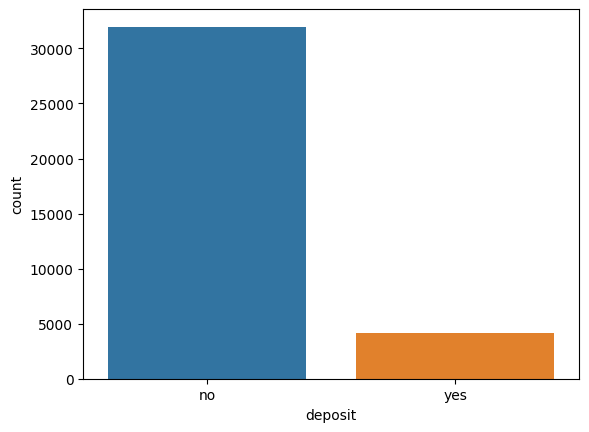

In [8]:
sns.countplot(x = target, data = train_set, hue = target)

In [9]:
features_cat = ["job", "marital", "education", "default", "housing", "loan", "contact", "month", "poutcome"]
features_num = ["age", "balance", "day", "duration", "campaign", "pdays", "previous"]

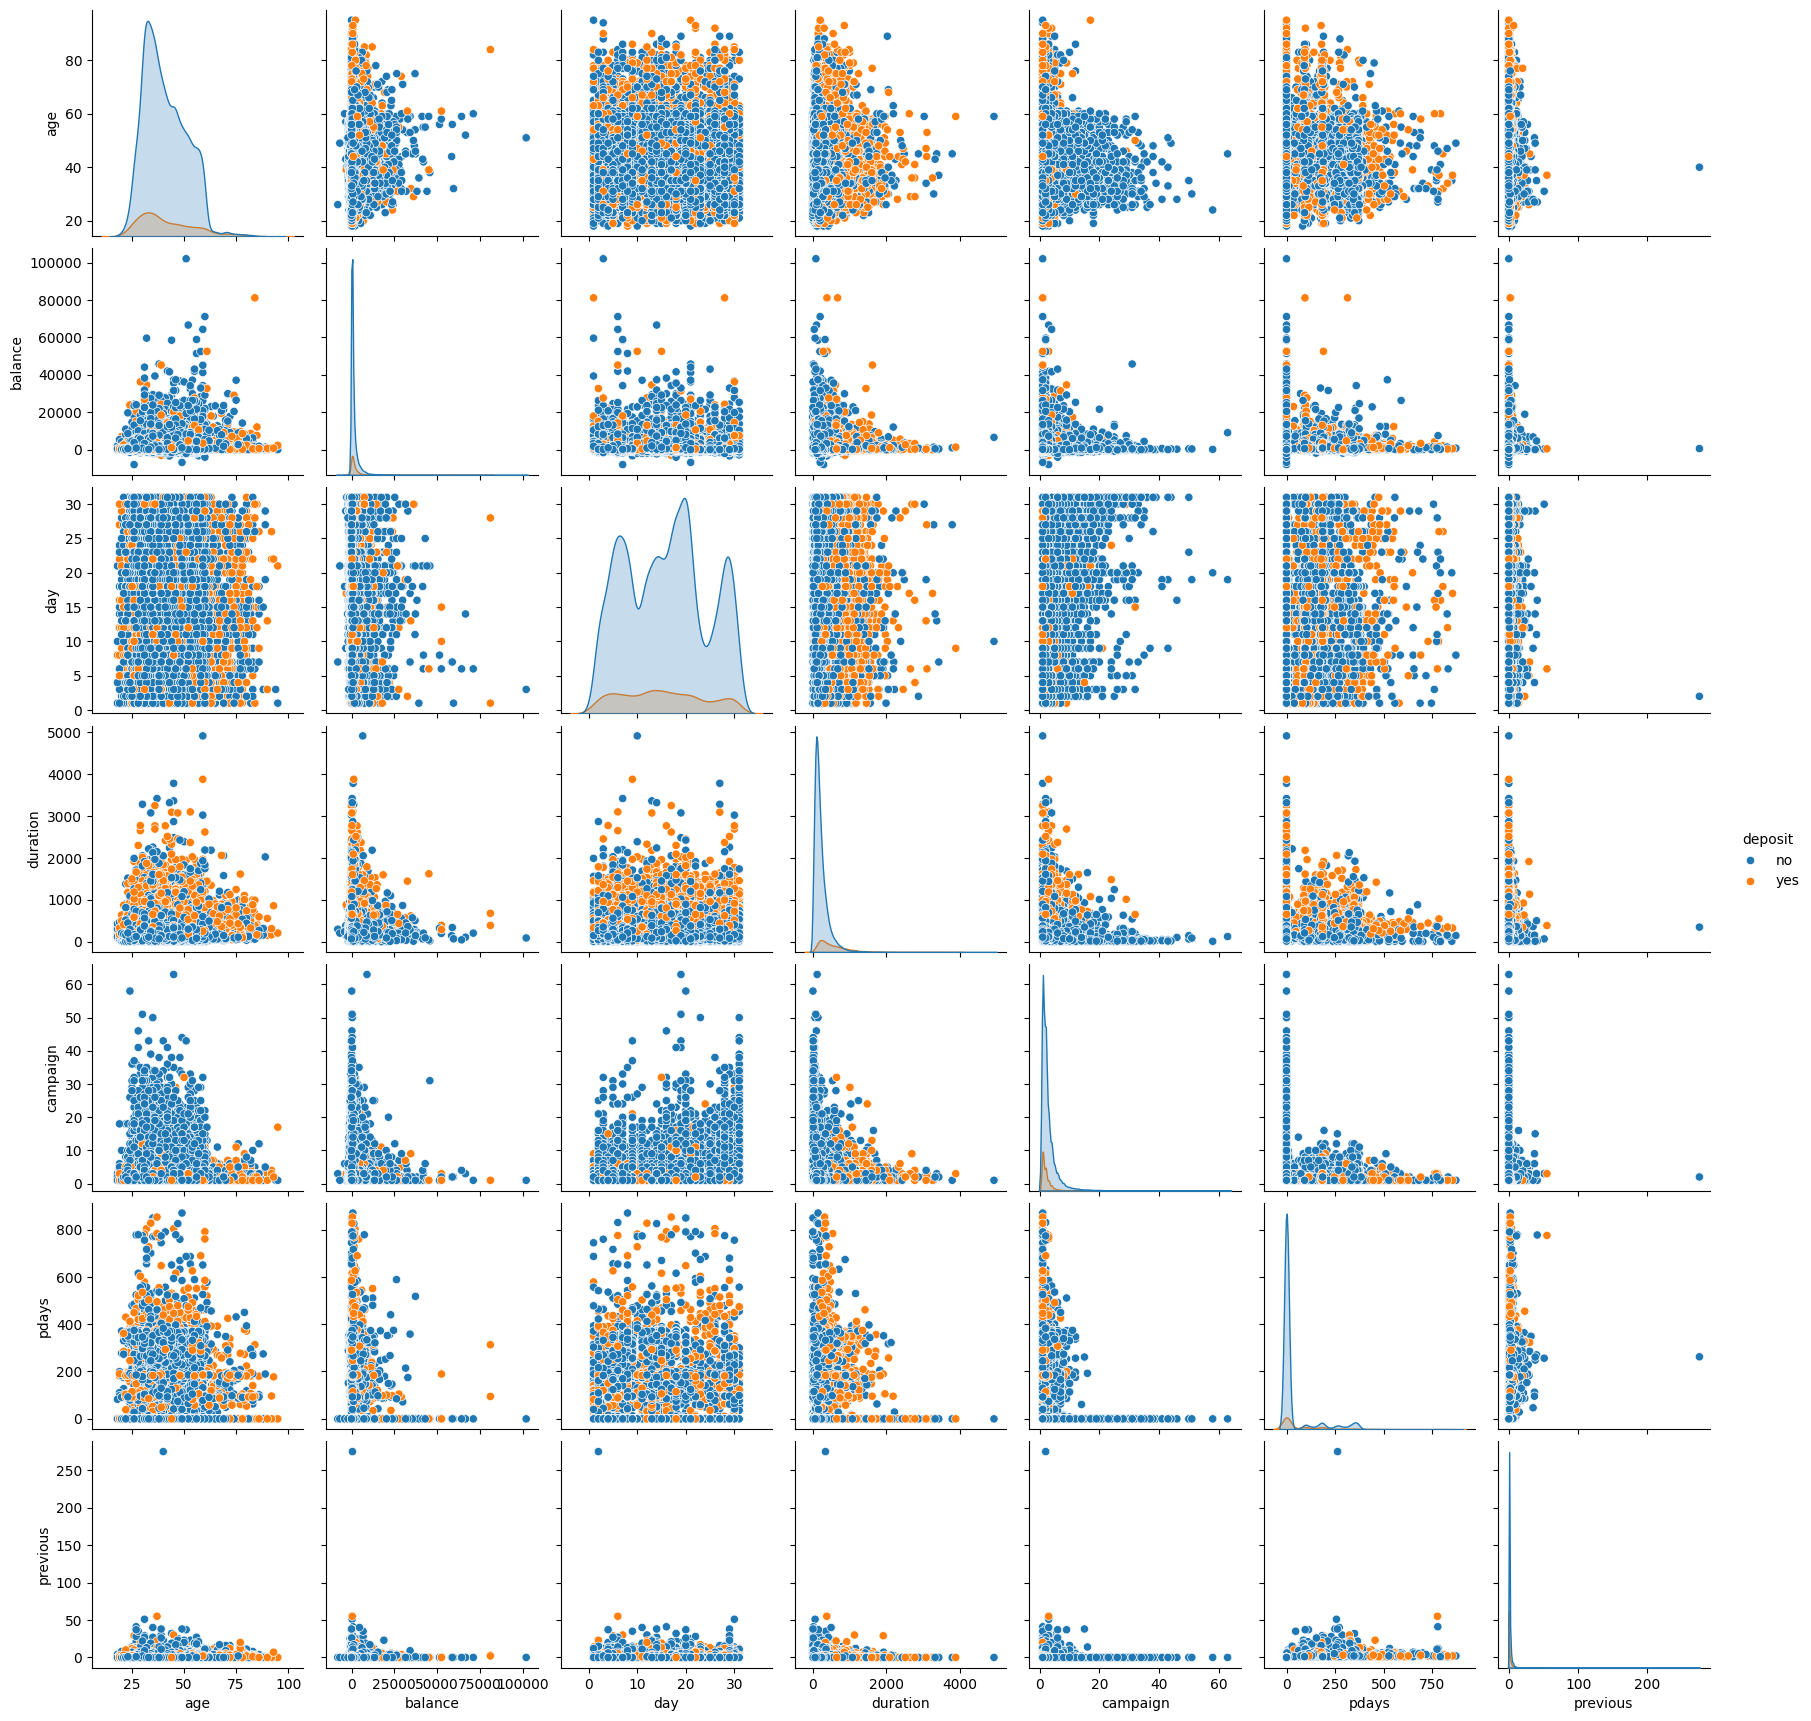

In [10]:
sns.pairplot(train_set[features_num + [target]], hue = target)

In [11]:
features_num = ["age","day", "duration"]

In [12]:
def plot_categorical_relationship_fin(df, cat_col1, cat_col2, relative_freq=False, show_values=False, size_group = 5):
    # Prepara los datos
    count_data = df.groupby([cat_col1, cat_col2]).size().reset_index(name='count')
    total_counts = df[cat_col1].value_counts()
    
    # Convierte a frecuencias relativas si se solicita
    if relative_freq:
        count_data['count'] = count_data.apply(lambda x: x['count'] / total_counts[x[cat_col1]], axis=1)

    # Si hay más de size_group categorías en cat_col1, las divide en grupos de size_group
    unique_categories = df[cat_col1].unique()
    if len(unique_categories) > size_group:
        num_plots = int(np.ceil(len(unique_categories) / size_group))

        for i in range(num_plots):
            # Selecciona un subconjunto de categorías para cada gráfico
            categories_subset = unique_categories[i * size_group:(i + 1) * size_group]
            data_subset = count_data[count_data[cat_col1].isin(categories_subset)]

            # Crea el gráfico
            plt.figure(figsize=(10, 6))
            ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=data_subset, order=categories_subset)

            # Añade títulos y etiquetas
            plt.title(f'Relación entre {cat_col1} y {cat_col2} - Grupo {i + 1}')
            plt.xlabel(cat_col1)
            plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
            plt.xticks(rotation=45)

            # Mostrar valores en el gráfico
            if show_values:
                for p in ax.patches:
                    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                                ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                                textcoords='offset points')

            # Muestra el gráfico
            plt.show()
    else:
        # Crea el gráfico para menos de size_group categorías
        plt.figure(figsize=(10, 6))
        ax = sns.barplot(x=cat_col1, y='count', hue=cat_col2, data=count_data)

        # Añade títulos y etiquetas
        plt.title(f'Relación entre {cat_col1} y {cat_col2}')
        plt.xlabel(cat_col1)
        plt.ylabel('Frecuencia' if relative_freq else 'Conteo')
        plt.xticks(rotation=45)

        # Mostrar valores en el gráfico
        if show_values:
            for p in ax.patches:
                ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                            ha='center', va='center', fontsize=10, color='black', xytext=(0, size_group),
                            textcoords='offset points')

        # Muestra el gráfico
        plt.show()

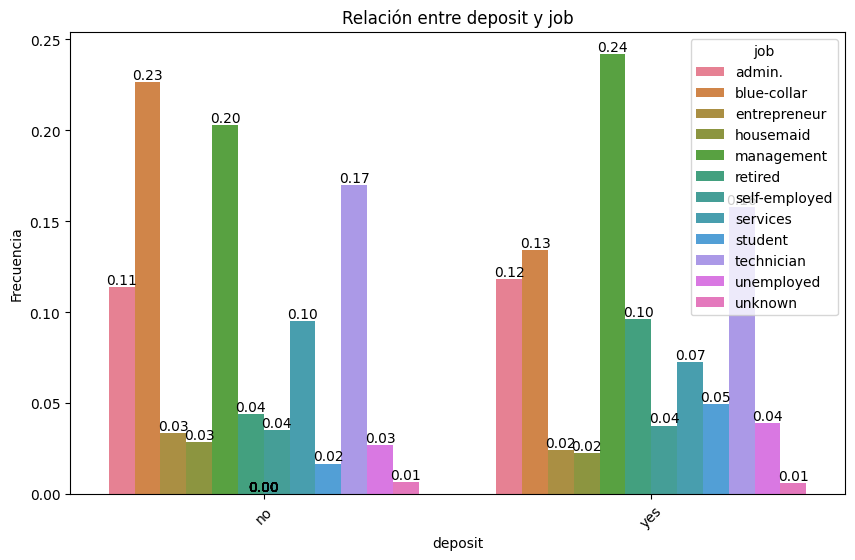

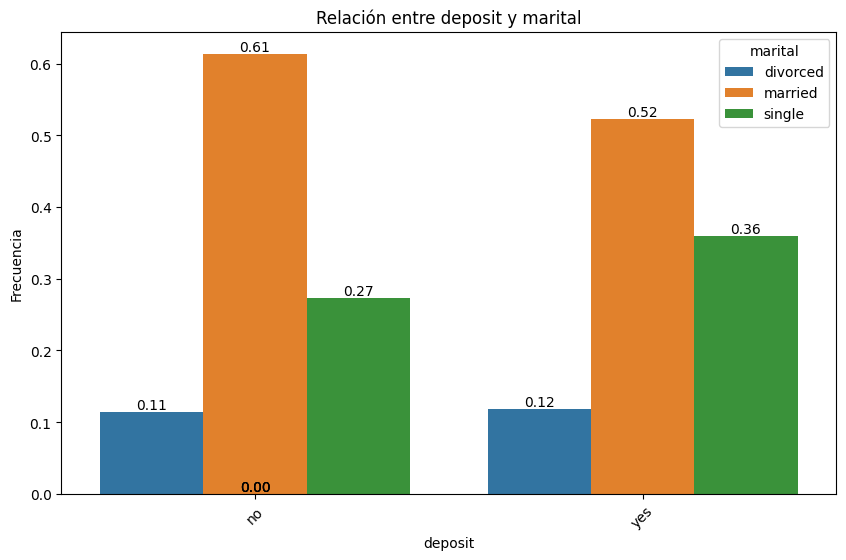

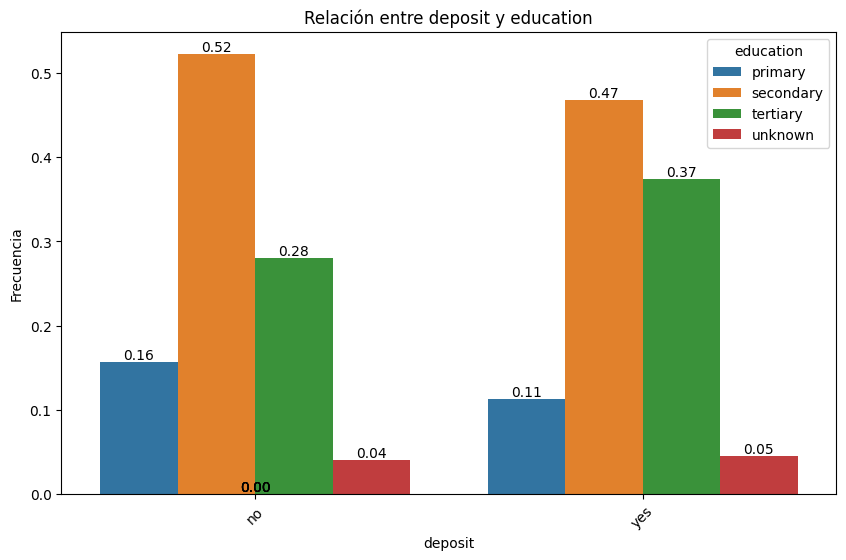

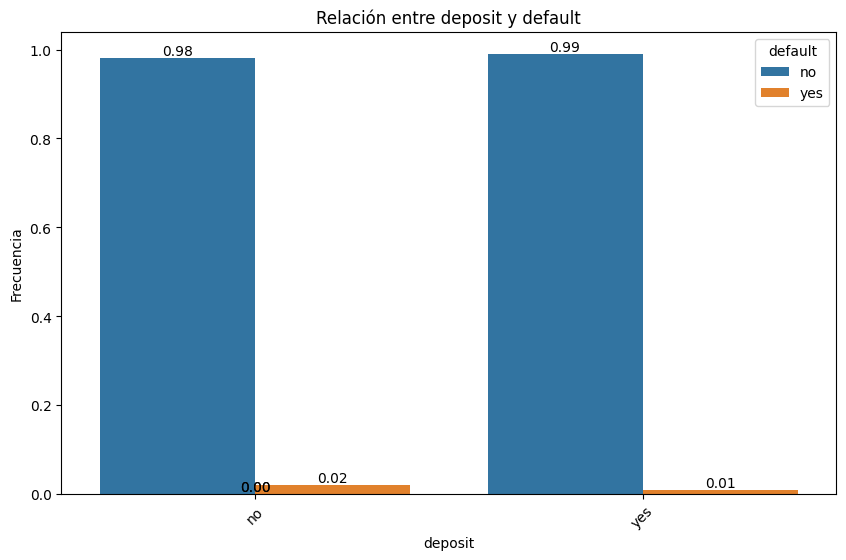

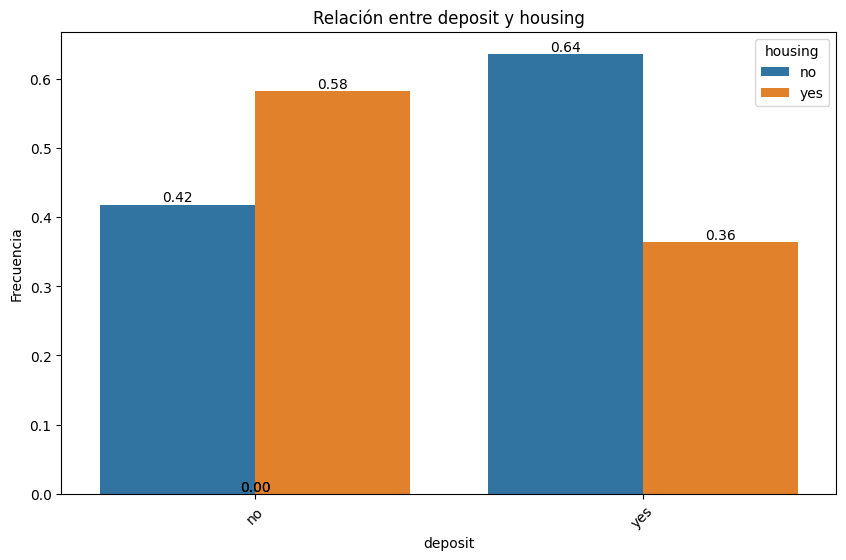

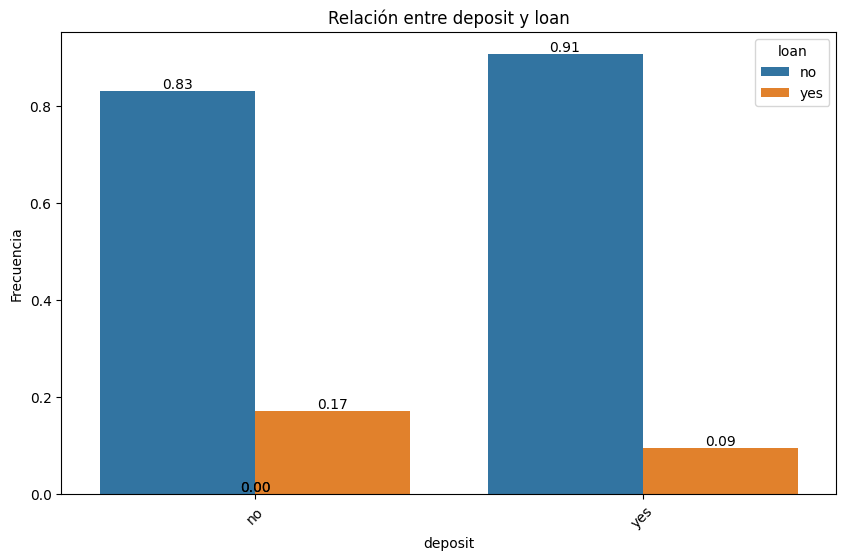

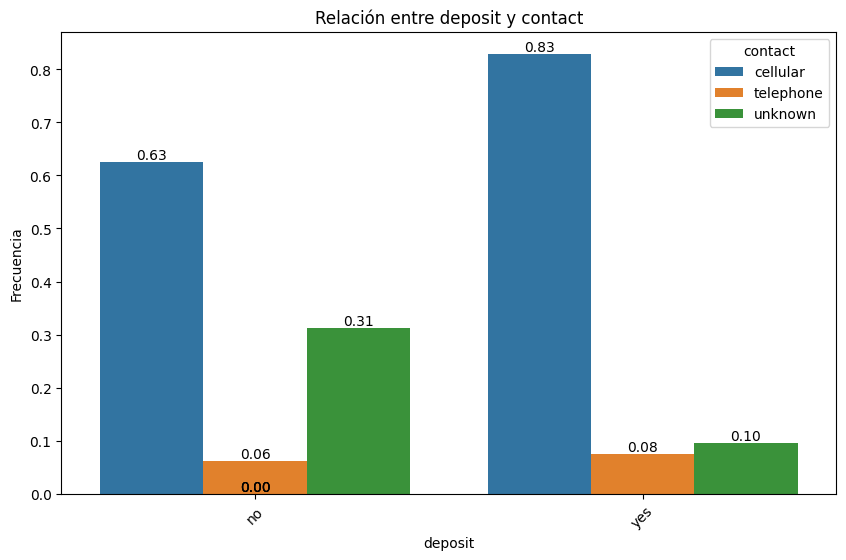

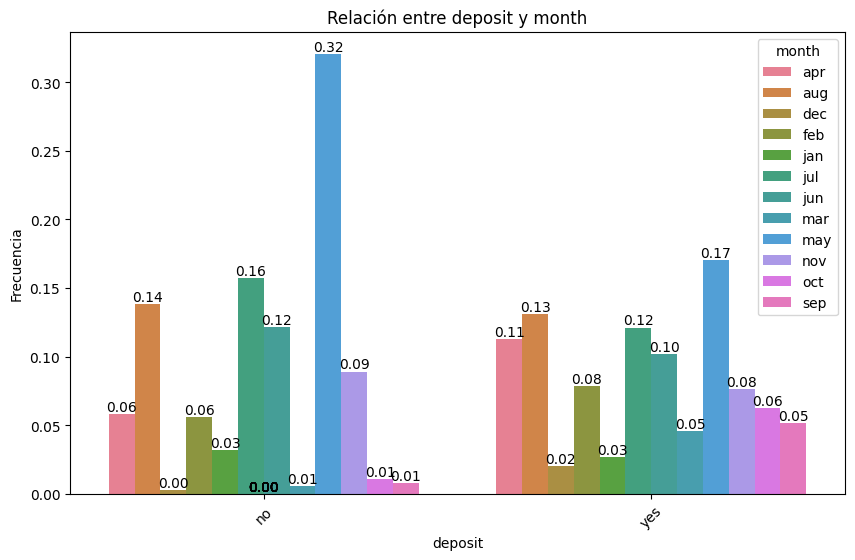

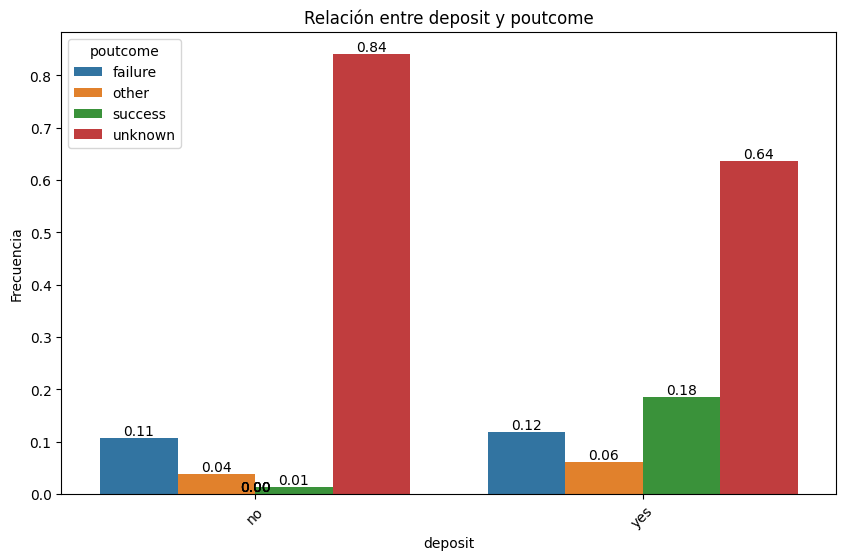

In [13]:
for feat in features_cat:
    plot_categorical_relationship_fin(train_set, target, feat, show_values=True, relative_freq=True)

In [14]:
features_cat = ["job", "housing", "contact", "month"]
features_num = ["age","day", "duration"]

In [15]:
# Ordinal encoder
categories = [['blue-collar', 'technician', 'admin.', 'management', 'services', 'unemployed', 'housemaid', 'retired', 'entrepreneur', 'unknown','student', 'self-employed'],
              ['no', 'yes'],
              ["cellular", "unknown", "telephone"],
              ['may','jun','jul','aug','oct','nov','dec','jan','feb','mar','apr','sep']]

encoder = OrdinalEncoder(categories= categories)

train_set[features_cat] = encoder.fit_transform(train_set[features_cat])
test_set[features_cat] = encoder.transform(test_set[features_cat])

In [16]:
train_set.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
3344,41,0.0,married,primary,no,849,1.0,no,1.0,15,0.0,72,1,-1,0,unknown,no
17965,49,1.0,married,primary,no,1415,1.0,no,0.0,30,2.0,269,2,-1,0,unknown,no
18299,42,2.0,married,secondary,no,3842,0.0,no,0.0,31,2.0,130,4,-1,0,unknown,no
10221,37,3.0,single,tertiary,no,-119,1.0,no,1.0,11,1.0,375,11,-1,0,unknown,no
32192,56,0.0,married,primary,no,3498,0.0,no,0.0,15,10.0,264,2,-1,0,unknown,yes


In [17]:
features_out = ["marital", "education", "default", "campaign", "balance", "pdays", "previous", "poutcome", "loan"]
train_set.drop(features_out, axis=1, inplace=True)
test_set.drop(features_out, axis=1, inplace=True)

train_set[target] = train_set[target].replace({'yes': 1, 'no': 0})
test_set[target] = test_set[target].replace({'yes': 1, 'no': 0})

/var/folders/p4/vjvzpsdd1dv3tv50bcvpf51m0000gn/T/ipykernel_2107/2126440152.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_set[target] = train_set[target].replace({'yes': 1, 'no': 0})
/var/folders/p4/vjvzpsdd1dv3tv50bcvpf51m0000gn/T/ipykernel_2107/2126440152.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_set[target] = test_set[target].replace({'yes': 1, 'no': 0})


In [18]:
train_set

,age,job,housing,contact,day,month,duration,deposit
3344,41,0.0,1.0,1.0,15,0.0,72,0
17965,49,1.0,1.0,0.0,30,2.0,269,0
18299,42,2.0,0.0,0.0,31,2.0,130,0
10221,37,3.0,1.0,1.0,11,1.0,375,0
32192,56,0.0,0.0,0.0,15,10.0,264,1
...,...,...,...,...,...,...,...,...
11284,44,6.0,0.0,1.0,18,1.0,2093,1
44732,23,10.0,0.0,0.0,8,11.0,210,0
38158,34,1.0,1.0,0.0,15,0.0,239,0
860,33,7.0,0.0,1.0,7,0.0,111,0


In [19]:
test_set

,age,job,housing,contact,day,month,duration,deposit
3776,40,0.0,1.0,1.0,16,0.0,192,0
9928,47,4.0,0.0,1.0,9,1.0,83,0
33409,25,10.0,1.0,0.0,20,10.0,226,0
31885,42,3.0,0.0,0.0,9,10.0,311,0
15738,56,3.0,0.0,0.0,21,2.0,121,0
...,...,...,...,...,...,...,...,...
13353,47,3.0,0.0,0.0,8,2.0,161,0
38732,32,0.0,1.0,0.0,15,0.0,692,1
5654,52,2.0,1.0,1.0,26,0.0,206,0
3779,40,2.0,1.0,1.0,16,0.0,171,0


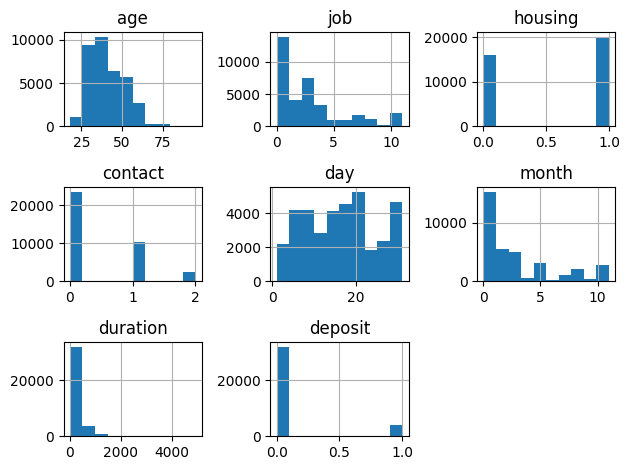

In [20]:
train_set.hist()
plt.tight_layout()

In [21]:
features_all = features_cat + features_num

In [22]:
train_set

,age,job,housing,contact,day,month,duration,deposit
3344,41,0.0,1.0,1.0,15,0.0,72,0
17965,49,1.0,1.0,0.0,30,2.0,269,0
18299,42,2.0,0.0,0.0,31,2.0,130,0
10221,37,3.0,1.0,1.0,11,1.0,375,0
32192,56,0.0,0.0,0.0,15,10.0,264,1
...,...,...,...,...,...,...,...,...
11284,44,6.0,0.0,1.0,18,1.0,2093,1
44732,23,10.0,0.0,0.0,8,11.0,210,0
38158,34,1.0,1.0,0.0,15,0.0,239,0
860,33,7.0,0.0,1.0,7,0.0,111,0


In [23]:
test_set

,age,job,housing,contact,day,month,duration,deposit
3776,40,0.0,1.0,1.0,16,0.0,192,0
9928,47,4.0,0.0,1.0,9,1.0,83,0
33409,25,10.0,1.0,0.0,20,10.0,226,0
31885,42,3.0,0.0,0.0,9,10.0,311,0
15738,56,3.0,0.0,0.0,21,2.0,121,0
...,...,...,...,...,...,...,...,...
13353,47,3.0,0.0,0.0,8,2.0,161,0
38732,32,0.0,1.0,0.0,15,0.0,692,1
5654,52,2.0,1.0,1.0,26,0.0,206,0
3779,40,2.0,1.0,1.0,16,0.0,171,0


In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Adaptamos el StandarScaler al X_train, pero luego usamos el mismo en el X_test (porque ya la media y la desviación son las del X_train)
scaler.fit(train_set[features_all]) 					
train_set[features_all] = scaler.transform(train_set[features_all])
test_set[features_all] = scaler.transform(test_set[features_all])

In [25]:
train_set.head()

,age,job,housing,contact,day,month,duration,deposit
3344,0.006515,-1.027783,0.892343,0.959741,-0.098218,-0.925708,-0.719756,0
17965,0.759937,-0.680986,0.892343,-0.681872,1.703422,-0.296366,0.047138,0
18299,0.100693,-0.334189,-1.120646,-0.681872,1.823532,-0.296366,-0.493970,0
10221,-0.370196,0.012609,0.892343,0.959741,-0.578656,-0.611037,0.459781,0
32192,1.419181,-1.027783,-1.120646,-0.681872,-0.098218,2.221002,0.027674,1


In [26]:
X_train = train_set[features_all]
y_train = train_set[target]

X_test = test_set[features_all]
y_test = test_set[target]

In [27]:
from sklearn.tree import DecisionTreeClassifier

# Instanciamos
tree_clas = DecisionTreeClassifier(max_depth=4, random_state=42)

tree_clas.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, random_state=42)

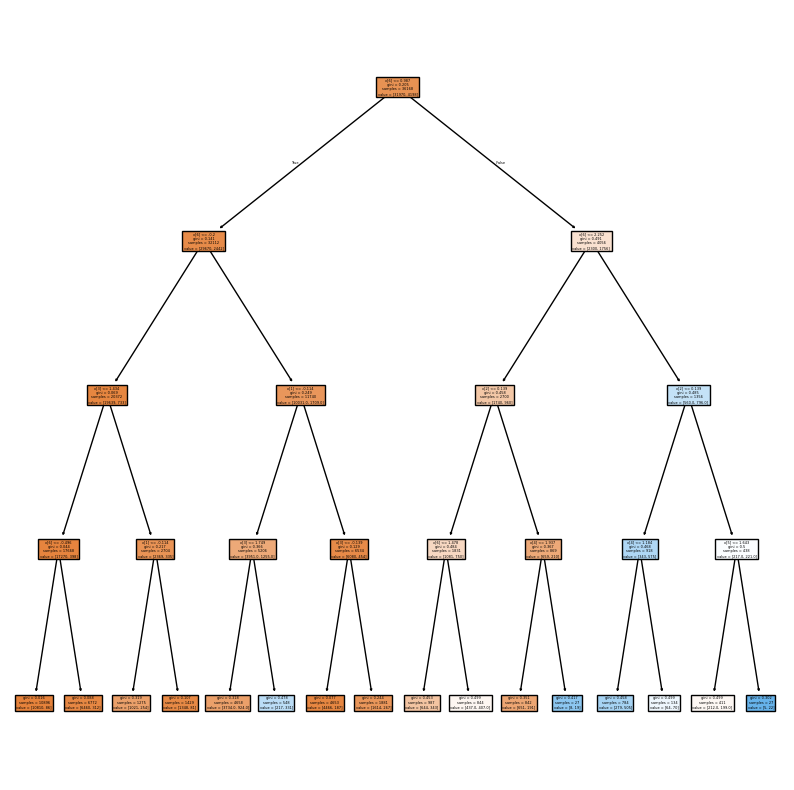

In [28]:
import sklearn
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
sklearn.tree.plot_tree(tree_clas, filled = True);

In [29]:
# Validación cruzada

from sklearn.model_selection import cross_val_score

arbol= np.sqrt(-cross_val_score(tree_clas, X_train, y_train, cv = 5, scoring= "neg_mean_squared_error"))
print("Arbol:", arbol.mean())

Arbol: 0.32907639711384856


In [30]:
# Probando hiperparámetros
# Random Search

from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import ElasticNet


model = ElasticNet(alpha=0.0001, l1_ratio=0.01)
model.fit(X_train, y_train)
print(model.score(X_train,y_train))
print("RMSE_train", root_mean_squared_error(y_train, model.predict(X_train)))
print(model.score(X_test, y_test))
print("RMSE_test", root_mean_squared_error(y_test, model.predict(X_test)))


0.19616465134073202
RMSE_train 0.28717828090503694
0.1986728145871064
RMSE_test 0.291570088367233


In [31]:
# Probando hiperparámetros
# Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0, 1, 0.01)
}

elastic = ElasticNet()

grid_search = GridSearchCV(elastic,
                           param_grid,
                           cv=10,
                           scoring='r2',
                           n_jobs=-1
                          )

grid_search.fit(X_train, y_train)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.344e+03, tolerance: 3.347e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+03, tolerance: 3.371e-01 Linear regression models with null weight for the l1 regularization term are mor

GridSearchCV(cv=10, estimator=ElasticNet(), n_jobs=-1,
             param_grid={'alpha': [1e-10, 0.0001, 0.01, 1, 5, 10, 20, 40],
                         'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
             scoring='r2')

In [32]:
model = ElasticNet(alpha=0.01, l1_ratio=0.97)
model.fit(X_train, y_train)
print(model.score(X_train,y_train))
print("RMSE_train", root_mean_squared_error(y_train, model.predict(X_train)))
print(model.score(X_test, y_test))
print("RMSE_test", root_mean_squared_error(y_test, model.predict(X_test)))

0.19228959057128092
RMSE_train 0.28786965094250216
0.1942994205687455
RMSE_test 0.2923646550506011


In [33]:
# Probando hiperparámetros
# Bayesian Search

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


def hyperopt_train_test(params, scoring = "r2"):
    model = ElasticNet(**params)
    return cross_val_score(model, X_train, y_train, 
                           cv=5, scoring= scoring).mean() # Aquí la métrica es r2 pero podemos poner la que queramos de las admitidas por la validación cruzada de sklearn


# Defininmos el "grid" (hiperparámetros y rango de valores)
space = {
    'alpha': hp.uniform('alpha', 0.0001, 1.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.0001, 1.0)
}

def f(params):
    r2 = hyperopt_train_test(params)
    return {'loss':-r2, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)


100%|██████████| 100/100 [00:02<00:00, 40.04trial/s, best loss: -0.19545918027878378]


In [34]:
model_bayes = ElasticNet(alpha=best['alpha'], l1_ratio=best['l1_ratio'])
model_bayes.fit(X_train, y_train)
model_bayes.score(X_test, y_test)

0.1986420926464625

In [35]:
# Regresión lineal

from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
print(log_reg.score(X_train,y_train))
print("RMSE", root_mean_squared_error(y_train, log_reg.predict(X_train)))
print(log_reg.score(X_test, y_test))
print("RMSE", root_mean_squared_error(y_test, log_reg.predict(X_test)))


0.8895708913957089
RMSE 0.3323087549317518
0.8852150834899922
RMSE 0.33879922743419555
